# Pré-requisitos e importações
Carrega as bibliotecas necessárias para processamento de texto, vetorização, modelos de Word2Vec e classificadores.


In [1]:
# No topo do notebook, em uma célula separada:
%pip install --upgrade gensim
%pip install kagglehub[pandas-datasets]

In [2]:
import pandas as pd
import numpy as np

# Download Kaggle
import kagglehub

# Deep Learning / NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

# Vetorizadores e embeddings
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

# Divisão de dados e classificadores
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Visualização dos resultados
import seaborn as sns
import matplotlib.pyplot as plt


# Download de recursos NLTK
Garante que os pacotes `punkt`, `stopwords` e `wordnet` estejam disponíveis.  
*(Se estiver em ambiente sem internet, baixe antes e aponte `nltk.data.path` para o local dos arquivos.)*


In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Download e Carregamento do Dataset

Lê o CSV de reviews do IMDB e converte o sentimento em rótulo binário. (https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)


In [4]:
# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [5]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


# Avaliando estado do Dataset

Entendo distribuição e informações

In [6]:
df.describe()

,label
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
 2   label      50000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


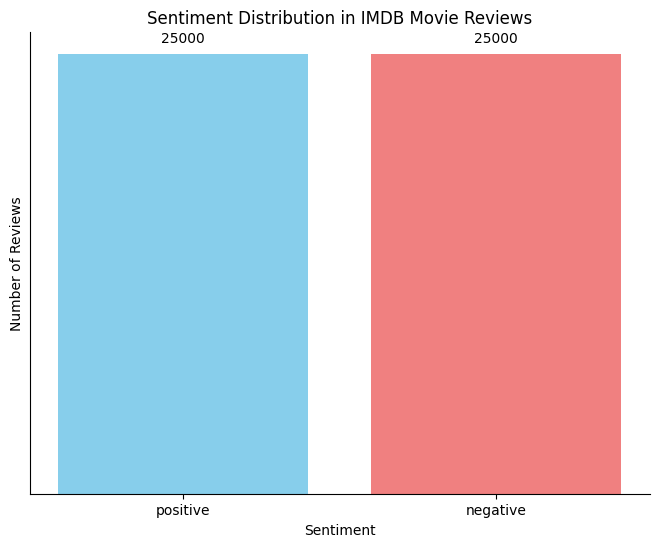

In [8]:
# Conta as ocorrências de cada sentimento
sentiment_counts = df['sentiment'].value_counts()

# Cria a figura e o axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plota o bar chart
bars = ax.bar(
    sentiment_counts.index,
    sentiment_counts.values,
    color=['skyblue', 'lightcoral']
)

# Adiciona os rótulos acima de cada barra
for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 500,
        yval,
        ha='center',
        va='bottom'
    )

# Remove as marcações e labels do eixo y
ax.set_yticks([])

# Define legendas e título
ax.set_xlabel("Sentiment")
ax.set_ylabel("Number of Reviews")
ax.set_title("Sentiment Distribution in IMDB Movie Reviews")

# Remove as spines superior e direita
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


# Função de pré-processamento
Tokeniza, filtra palavras não alfabéticas e stopwords, e aplica lemmatization.


In [9]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text: str) -> list[str]:
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens


# Divisão treino / teste
Usa 80% dos dados para treino e 20% para teste, estratificando pelo rótulo.


In [10]:
X = df['review']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# Configuração dos vetorizadores BoW e TF-IDF
Instancia e encaixa ambos os vetorizadores no conjunto de treino.


In [11]:
vectorizers = {
    'BoW': CountVectorizer(analyzer=preprocess),
    'TF-IDF': TfidfVectorizer(analyzer=preprocess)
}

X_train_vec = {}
X_test_vec  = {}

for name, vec in vectorizers.items():
    vec.fit(X_train)
    X_train_vec[name] = vec.transform(X_train)
    X_test_vec[name]  = vec.transform(X_test)


# Treinamento de embeddings Word2Vec
Gera vetores médios de cada documento baseado no modelo treinado no treino.


In [12]:
# Prepara listas de tokens
tokenized_train = X_train.apply(preprocess)

# Treina o modelo Word2Vec
w2v_model = Word2Vec(
    sentences=tokenized_train,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    seed=42
)

# Função para converter documento em vetor médio
def doc_to_vec(tokens: list[str]) -> np.ndarray:
    vecs = [w2v_model.wv[t] for t in tokens if t in w2v_model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(w2v_model.vector_size)

# Aplica ao treino e teste
X_train_vec['Word2Vec'] = np.vstack(X_train.apply(lambda x: doc_to_vec(preprocess(x))))
X_test_vec['Word2Vec']  = np.vstack(X_test.apply(lambda x: doc_to_vec(preprocess(x))))


# Definição dos classificadores
Utiliza Regressão Logística e Random Forest para comparar desempenho.


In [13]:
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}


# Treinamento e avaliação
Para cada combinação de vetor e classificador, calcula acurácia no conjunto de teste.


In [14]:
results = []
for vec_name, Xtr in X_train_vec.items():
    Xte = X_test_vec[vec_name]
    for clf_name, clf in classifiers.items():
        clf.fit(Xtr, y_train)
        acc = clf.score(Xte, y_test)
        results.append({
            'Vectorization': vec_name,
            'Classifier': clf_name,
            'Accuracy': acc
        })

results_df = pd.DataFrame(results)


# Exibição dos resultados
Mostra em formato de tabela de fácil leitura.


Classifier,Vectorization,Logistic Regression,Random Forest
0,BoW,0.8845,0.8599
1,TF-IDF,0.8916,0.8587
2,Word2Vec,0.8567,0.8287


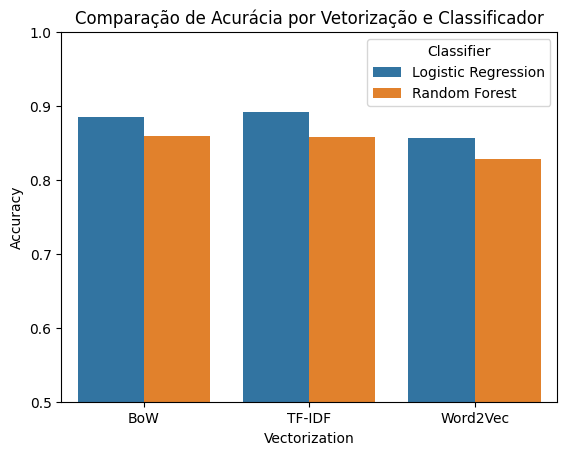

In [15]:
# Tabela pivotada
pivot = results_df.pivot(
    index='Vectorization',
    columns='Classifier',
    values='Accuracy'
).reset_index()
display(pivot)

# Visualização opcional
sns.barplot(
    data=results_df,
    x='Vectorization',
    y='Accuracy',
    hue='Classifier'
)
plt.title("Comparação de Acurácia por Vetorização e Classificador")
plt.ylim(0.5, 1.0)
plt.show()


In [24]:
from sklearn.metrics          import confusion_matrix
from sklearn.base             import clone
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_confusion(cm, title: str):
    """Helper para desenhar a matriz de confusão."""
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title(title)
    plt.show()

def evaluate_model(vec_name: str, clf_name: str) -> pd.DataFrame:
    """
    1) Clona o classificador 'clf_name'
    2) Treina em X_train_vec[vec_name], y_train
    3) Prediz em X_test_vec[vec_name]
    4) Plota matriz de confusão
    5) Retorna DataFrame com [review, true_label, pred_label]
    """
    # 1) prepara dados
    Xtr = X_train_vec[vec_name]
    Xte = X_test_vec[vec_name]

    # 2) clona e treina
    clf = clone(classifiers[clf_name])
    clf.fit(Xtr, y_train)

    # 3) prediz
    y_pred = clf.predict(Xte)

    # 4) matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion(cm, f"Matriz: {vec_name} + {clf_name}")

    # 5) DataFrame de exemplo
    reviews = X_test.reset_index(drop=True)
    trues   = y_test.reset_index(drop=True).map({1: 'positive', 0: 'negative'})
    preds   = pd.Series(y_pred).map({1: 'positive', 0: 'negative'})

    df_eval = pd.DataFrame({
        'review':     reviews,
        'true_label': trues,
        'pred_label': preds
    })
    return df_eval

# Analise de teste para cada Modelo


===== Avaliação: BoW + Logistic Regression =====


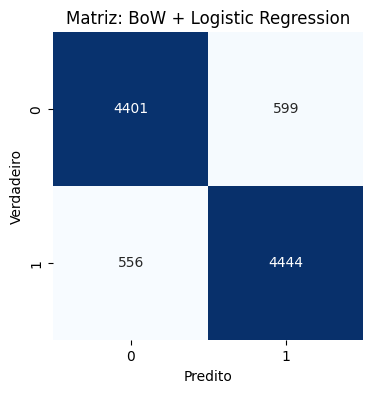

,review,true_label,pred_label
0,"Yes, MTV there really is a way to market Daria. What started as a clever teenage angst-""comment on everything that sucks and make the viewer feel better about their sucky teenage life"" sitcom now mutated into a ""how you should deal with your problems""-charade. I used to watch Daria all the time and loved it. Now, sitting here after watching the so called ""movie"" I can only wonder what the point of this all was. Daria tells us how to lead out life in college? Excuse me? didn't the point Daria made every episode that what you like to do is ok, as long as it is ok with yourself no matter what the rest of the sick sad world thinks of it? This entire thing reminded me of the scene in ""Reality Bites"" the movie channel shows the documentry for the first time.",negative,positive
1,"The story of the bride fair is an amusing and engaging one, and it is to the filmmaker's credit that he sets out to portray rural Minnesotans with the same respect ordinarily reserved for Coast-dwellers. It is weird, though, to find an independent movie, the brainchild of a single person, that is as unambitious and cliché-ridden as a committee-brewed Hollywood potboiler.<br /><br />The portrait of rural people is intended to be affectionate, I think, but these characters don't ring true to me--I have had quite a few meals in small-town diners, but never overheard a debate on the merits of different nineteenth-century English novelists. One might suggest that writer/director Semans has no more experience with rural culture than the Coen brothers, and considerably less satiric verve.",negative,positive
2,"A team varied between Scully and Mulder, two other scientists, a pilot, and the guy who plays Bana on Seinfeld, go up to an Arctic research post where all members have died off by either killing each other or killing themselves. They discover there's a worm- a virus- that is parasitic to the point of madness and death. The problem is, after a certain dog lashes out, anyone could be infected, but who? This is not just my favorite episode of season 1, but also one of my favorites from the show. The Arctic environment encloses the characters and, of course like Carpenter's the Thing, it's a lot of fun watching these even-tempered characters suddenly start to flip out in dramatic scenes. And the visual effects of the worm and its effects under the skin are cheesy, I didn't mind them at all. The drama between the characters ends up working more than it would usually because of the tension and because all of the actors (including the Bana guy) understand what's going on in the story. And, as usual, I loved the ambiguity of the ending. Highly recommended.",positive,positive
3,"This was a popular movie probably because of the humor in it, the fast-moving story, an underdog character who shuts up all the loudmouths, etc. Funny thing is, you probably couldn't make a movie with this title if you substituted anybody but ""white"" as anything else would be deemed racist by the PC police. <br /><br />Nonetheless, Woody Harrleson as the white guy who turns out to be as good if not better than any of the black basketball players, is interesting as is his main counterpart Wesley Snipes.<br /><br />Snipes had a lot of funny put-down lines, providing much of the humor. The bad part of the film - which doesn't bother a lot of people - is the extreme profanity in here and the sleaziness of all the characters. That includes Woody's girlfriend, played by Rosie Perez. There are no really clean, nice people in this movie. For that reason, I can't honestly recommend the film, at least not to friends or those who are offended by a lotof profanity",negative,negative
4,"This movie made me so angry!! Here I am thinking that here's a new horror movie, one w/a sense of intelligence & then the movie starts. The scenery, the delivery of lines, the costumes, the fake gore, must I go on? There are porno movies out with better dialog than this. I underst


===== Avaliação: BoW + Random Forest =====


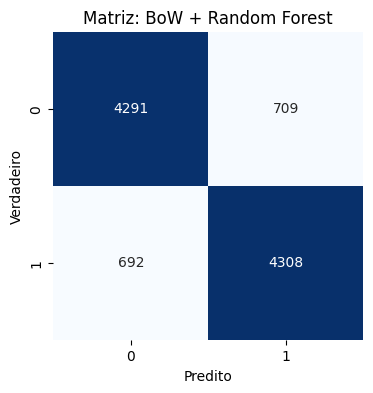

,review,true_label,pred_label
0,"Yes, MTV there really is a way to market Daria. What started as a clever teenage angst-""comment on everything that sucks and make the viewer feel better about their sucky teenage life"" sitcom now mutated into a ""how you should deal with your problems""-charade. I used to watch Daria all the time and loved it. Now, sitting here after watching the so called ""movie"" I can only wonder what the point of this all was. Daria tells us how to lead out life in college? Excuse me? didn't the point Daria made every episode that what you like to do is ok, as long as it is ok with yourself no matter what the rest of the sick sad world thinks of it? This entire thing reminded me of the scene in ""Reality Bites"" the movie channel shows the documentry for the first time.",negative,negative
1,"The story of the bride fair is an amusing and engaging one, and it is to the filmmaker's credit that he sets out to portray rural Minnesotans with the same respect ordinarily reserved for Coast-dwellers. It is weird, though, to find an independent movie, the brainchild of a single person, that is as unambitious and cliché-ridden as a committee-brewed Hollywood potboiler.<br /><br />The portrait of rural people is intended to be affectionate, I think, but these characters don't ring true to me--I have had quite a few meals in small-town diners, but never overheard a debate on the merits of different nineteenth-century English novelists. One might suggest that writer/director Semans has no more experience with rural culture than the Coen brothers, and considerably less satiric verve.",negative,positive
2,"A team varied between Scully and Mulder, two other scientists, a pilot, and the guy who plays Bana on Seinfeld, go up to an Arctic research post where all members have died off by either killing each other or killing themselves. They discover there's a worm- a virus- that is parasitic to the point of madness and death. The problem is, after a certain dog lashes out, anyone could be infected, but who? This is not just my favorite episode of season 1, but also one of my favorites from the show. The Arctic environment encloses the characters and, of course like Carpenter's the Thing, it's a lot of fun watching these even-tempered characters suddenly start to flip out in dramatic scenes. And the visual effects of the worm and its effects under the skin are cheesy, I didn't mind them at all. The drama between the characters ends up working more than it would usually because of the tension and because all of the actors (including the Bana guy) understand what's going on in the story. And, as usual, I loved the ambiguity of the ending. Highly recommended.",positive,positive
3,"This was a popular movie probably because of the humor in it, the fast-moving story, an underdog character who shuts up all the loudmouths, etc. Funny thing is, you probably couldn't make a movie with this title if you substituted anybody but ""white"" as anything else would be deemed racist by the PC police. <br /><br />Nonetheless, Woody Harrleson as the white guy who turns out to be as good if not better than any of the black basketball players, is interesting as is his main counterpart Wesley Snipes.<br /><br />Snipes had a lot of funny put-down lines, providing much of the humor. The bad part of the film - which doesn't bother a lot of people - is the extreme profanity in here and the sleaziness of all the characters. That includes Woody's girlfriend, played by Rosie Perez. There are no really clean, nice people in this movie. For that reason, I can't honestly recommend the film, at least not to friends or those who are offended by a lotof profanity",negative,negative
4,"This movie made me so angry!! Here I am thinking that here's a new horror movie, one w/a sense of intelligence & then the movie starts. The scenery, the delivery of lines, the costumes, the fake gore, must I go on? There are porno movies out with better dialog than this. I underst


===== Avaliação: TF-IDF + Logistic Regression =====


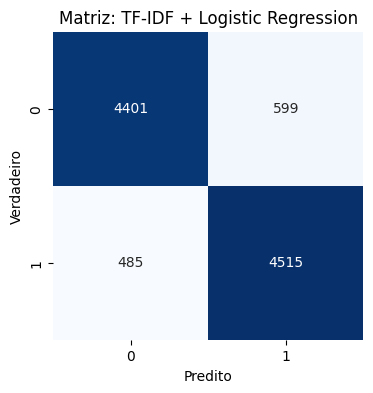

,review,true_label,pred_label
0,"Yes, MTV there really is a way to market Daria. What started as a clever teenage angst-""comment on everything that sucks and make the viewer feel better about their sucky teenage life"" sitcom now mutated into a ""how you should deal with your problems""-charade. I used to watch Daria all the time and loved it. Now, sitting here after watching the so called ""movie"" I can only wonder what the point of this all was. Daria tells us how to lead out life in college? Excuse me? didn't the point Daria made every episode that what you like to do is ok, as long as it is ok with yourself no matter what the rest of the sick sad world thinks of it? This entire thing reminded me of the scene in ""Reality Bites"" the movie channel shows the documentry for the first time.",negative,negative
1,"The story of the bride fair is an amusing and engaging one, and it is to the filmmaker's credit that he sets out to portray rural Minnesotans with the same respect ordinarily reserved for Coast-dwellers. It is weird, though, to find an independent movie, the brainchild of a single person, that is as unambitious and cliché-ridden as a committee-brewed Hollywood potboiler.<br /><br />The portrait of rural people is intended to be affectionate, I think, but these characters don't ring true to me--I have had quite a few meals in small-town diners, but never overheard a debate on the merits of different nineteenth-century English novelists. One might suggest that writer/director Semans has no more experience with rural culture than the Coen brothers, and considerably less satiric verve.",negative,positive
2,"A team varied between Scully and Mulder, two other scientists, a pilot, and the guy who plays Bana on Seinfeld, go up to an Arctic research post where all members have died off by either killing each other or killing themselves. They discover there's a worm- a virus- that is parasitic to the point of madness and death. The problem is, after a certain dog lashes out, anyone could be infected, but who? This is not just my favorite episode of season 1, but also one of my favorites from the show. The Arctic environment encloses the characters and, of course like Carpenter's the Thing, it's a lot of fun watching these even-tempered characters suddenly start to flip out in dramatic scenes. And the visual effects of the worm and its effects under the skin are cheesy, I didn't mind them at all. The drama between the characters ends up working more than it would usually because of the tension and because all of the actors (including the Bana guy) understand what's going on in the story. And, as usual, I loved the ambiguity of the ending. Highly recommended.",positive,positive
3,"This was a popular movie probably because of the humor in it, the fast-moving story, an underdog character who shuts up all the loudmouths, etc. Funny thing is, you probably couldn't make a movie with this title if you substituted anybody but ""white"" as anything else would be deemed racist by the PC police. <br /><br />Nonetheless, Woody Harrleson as the white guy who turns out to be as good if not better than any of the black basketball players, is interesting as is his main counterpart Wesley Snipes.<br /><br />Snipes had a lot of funny put-down lines, providing much of the humor. The bad part of the film - which doesn't bother a lot of people - is the extreme profanity in here and the sleaziness of all the characters. That includes Woody's girlfriend, played by Rosie Perez. There are no really clean, nice people in this movie. For that reason, I can't honestly recommend the film, at least not to friends or those who are offended by a lotof profanity",negative,negative
4,"This movie made me so angry!! Here I am thinking that here's a new horror movie, one w/a sense of intelligence & then the movie starts. The scenery, the delivery of lines, the costumes, the fake gore, must I go on? There are porno movies out with better dialog than this. I underst


===== Avaliação: TF-IDF + Random Forest =====


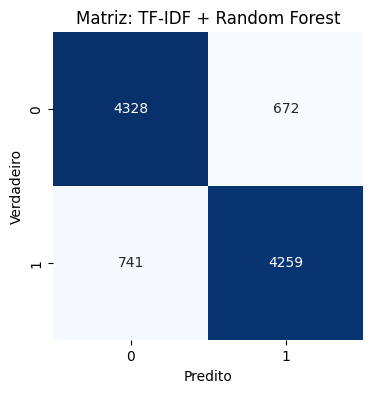

,review,true_label,pred_label
0,"Yes, MTV there really is a way to market Daria. What started as a clever teenage angst-""comment on everything that sucks and make the viewer feel better about their sucky teenage life"" sitcom now mutated into a ""how you should deal with your problems""-charade. I used to watch Daria all the time and loved it. Now, sitting here after watching the so called ""movie"" I can only wonder what the point of this all was. Daria tells us how to lead out life in college? Excuse me? didn't the point Daria made every episode that what you like to do is ok, as long as it is ok with yourself no matter what the rest of the sick sad world thinks of it? This entire thing reminded me of the scene in ""Reality Bites"" the movie channel shows the documentry for the first time.",negative,negative
1,"The story of the bride fair is an amusing and engaging one, and it is to the filmmaker's credit that he sets out to portray rural Minnesotans with the same respect ordinarily reserved for Coast-dwellers. It is weird, though, to find an independent movie, the brainchild of a single person, that is as unambitious and cliché-ridden as a committee-brewed Hollywood potboiler.<br /><br />The portrait of rural people is intended to be affectionate, I think, but these characters don't ring true to me--I have had quite a few meals in small-town diners, but never overheard a debate on the merits of different nineteenth-century English novelists. One might suggest that writer/director Semans has no more experience with rural culture than the Coen brothers, and considerably less satiric verve.",negative,positive
2,"A team varied between Scully and Mulder, two other scientists, a pilot, and the guy who plays Bana on Seinfeld, go up to an Arctic research post where all members have died off by either killing each other or killing themselves. They discover there's a worm- a virus- that is parasitic to the point of madness and death. The problem is, after a certain dog lashes out, anyone could be infected, but who? This is not just my favorite episode of season 1, but also one of my favorites from the show. The Arctic environment encloses the characters and, of course like Carpenter's the Thing, it's a lot of fun watching these even-tempered characters suddenly start to flip out in dramatic scenes. And the visual effects of the worm and its effects under the skin are cheesy, I didn't mind them at all. The drama between the characters ends up working more than it would usually because of the tension and because all of the actors (including the Bana guy) understand what's going on in the story. And, as usual, I loved the ambiguity of the ending. Highly recommended.",positive,positive
3,"This was a popular movie probably because of the humor in it, the fast-moving story, an underdog character who shuts up all the loudmouths, etc. Funny thing is, you probably couldn't make a movie with this title if you substituted anybody but ""white"" as anything else would be deemed racist by the PC police. <br /><br />Nonetheless, Woody Harrleson as the white guy who turns out to be as good if not better than any of the black basketball players, is interesting as is his main counterpart Wesley Snipes.<br /><br />Snipes had a lot of funny put-down lines, providing much of the humor. The bad part of the film - which doesn't bother a lot of people - is the extreme profanity in here and the sleaziness of all the characters. That includes Woody's girlfriend, played by Rosie Perez. There are no really clean, nice people in this movie. For that reason, I can't honestly recommend the film, at least not to friends or those who are offended by a lotof profanity",negative,negative
4,"This movie made me so angry!! Here I am thinking that here's a new horror movie, one w/a sense of intelligence & then the movie starts. The scenery, the delivery of lines, the costumes, the fake gore, must I go on? There are porno movies out with better dialog than this. I underst


===== Avaliação: Word2Vec + Logistic Regression =====


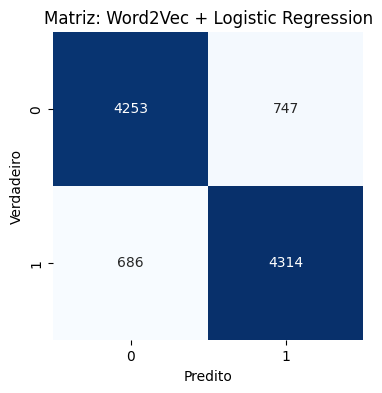

,review,true_label,pred_label
0,"Yes, MTV there really is a way to market Daria. What started as a clever teenage angst-""comment on everything that sucks and make the viewer feel better about their sucky teenage life"" sitcom now mutated into a ""how you should deal with your problems""-charade. I used to watch Daria all the time and loved it. Now, sitting here after watching the so called ""movie"" I can only wonder what the point of this all was. Daria tells us how to lead out life in college? Excuse me? didn't the point Daria made every episode that what you like to do is ok, as long as it is ok with yourself no matter what the rest of the sick sad world thinks of it? This entire thing reminded me of the scene in ""Reality Bites"" the movie channel shows the documentry for the first time.",negative,negative
1,"The story of the bride fair is an amusing and engaging one, and it is to the filmmaker's credit that he sets out to portray rural Minnesotans with the same respect ordinarily reserved for Coast-dwellers. It is weird, though, to find an independent movie, the brainchild of a single person, that is as unambitious and cliché-ridden as a committee-brewed Hollywood potboiler.<br /><br />The portrait of rural people is intended to be affectionate, I think, but these characters don't ring true to me--I have had quite a few meals in small-town diners, but never overheard a debate on the merits of different nineteenth-century English novelists. One might suggest that writer/director Semans has no more experience with rural culture than the Coen brothers, and considerably less satiric verve.",negative,positive
2,"A team varied between Scully and Mulder, two other scientists, a pilot, and the guy who plays Bana on Seinfeld, go up to an Arctic research post where all members have died off by either killing each other or killing themselves. They discover there's a worm- a virus- that is parasitic to the point of madness and death. The problem is, after a certain dog lashes out, anyone could be infected, but who? This is not just my favorite episode of season 1, but also one of my favorites from the show. The Arctic environment encloses the characters and, of course like Carpenter's the Thing, it's a lot of fun watching these even-tempered characters suddenly start to flip out in dramatic scenes. And the visual effects of the worm and its effects under the skin are cheesy, I didn't mind them at all. The drama between the characters ends up working more than it would usually because of the tension and because all of the actors (including the Bana guy) understand what's going on in the story. And, as usual, I loved the ambiguity of the ending. Highly recommended.",positive,positive
3,"This was a popular movie probably because of the humor in it, the fast-moving story, an underdog character who shuts up all the loudmouths, etc. Funny thing is, you probably couldn't make a movie with this title if you substituted anybody but ""white"" as anything else would be deemed racist by the PC police. <br /><br />Nonetheless, Woody Harrleson as the white guy who turns out to be as good if not better than any of the black basketball players, is interesting as is his main counterpart Wesley Snipes.<br /><br />Snipes had a lot of funny put-down lines, providing much of the humor. The bad part of the film - which doesn't bother a lot of people - is the extreme profanity in here and the sleaziness of all the characters. That includes Woody's girlfriend, played by Rosie Perez. There are no really clean, nice people in this movie. For that reason, I can't honestly recommend the film, at least not to friends or those who are offended by a lotof profanity",negative,negative
4,"This movie made me so angry!! Here I am thinking that here's a new horror movie, one w/a sense of intelligence & then the movie starts. The scenery, the delivery of lines, the costumes, the fake gore, must I go on? There are porno movies out with better dialog than this. I underst


===== Avaliação: Word2Vec + Random Forest =====


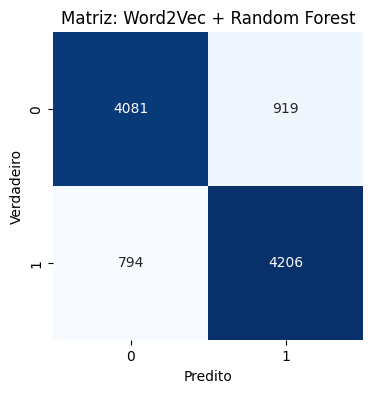

,review,true_label,pred_label
0,"Yes, MTV there really is a way to market Daria. What started as a clever teenage angst-""comment on everything that sucks and make the viewer feel better about their sucky teenage life"" sitcom now mutated into a ""how you should deal with your problems""-charade. I used to watch Daria all the time and loved it. Now, sitting here after watching the so called ""movie"" I can only wonder what the point of this all was. Daria tells us how to lead out life in college? Excuse me? didn't the point Daria made every episode that what you like to do is ok, as long as it is ok with yourself no matter what the rest of the sick sad world thinks of it? This entire thing reminded me of the scene in ""Reality Bites"" the movie channel shows the documentry for the first time.",negative,negative
1,"The story of the bride fair is an amusing and engaging one, and it is to the filmmaker's credit that he sets out to portray rural Minnesotans with the same respect ordinarily reserved for Coast-dwellers. It is weird, though, to find an independent movie, the brainchild of a single person, that is as unambitious and cliché-ridden as a committee-brewed Hollywood potboiler.<br /><br />The portrait of rural people is intended to be affectionate, I think, but these characters don't ring true to me--I have had quite a few meals in small-town diners, but never overheard a debate on the merits of different nineteenth-century English novelists. One might suggest that writer/director Semans has no more experience with rural culture than the Coen brothers, and considerably less satiric verve.",negative,positive
2,"A team varied between Scully and Mulder, two other scientists, a pilot, and the guy who plays Bana on Seinfeld, go up to an Arctic research post where all members have died off by either killing each other or killing themselves. They discover there's a worm- a virus- that is parasitic to the point of madness and death. The problem is, after a certain dog lashes out, anyone could be infected, but who? This is not just my favorite episode of season 1, but also one of my favorites from the show. The Arctic environment encloses the characters and, of course like Carpenter's the Thing, it's a lot of fun watching these even-tempered characters suddenly start to flip out in dramatic scenes. And the visual effects of the worm and its effects under the skin are cheesy, I didn't mind them at all. The drama between the characters ends up working more than it would usually because of the tension and because all of the actors (including the Bana guy) understand what's going on in the story. And, as usual, I loved the ambiguity of the ending. Highly recommended.",positive,negative
3,"This was a popular movie probably because of the humor in it, the fast-moving story, an underdog character who shuts up all the loudmouths, etc. Funny thing is, you probably couldn't make a movie with this title if you substituted anybody but ""white"" as anything else would be deemed racist by the PC police. <br /><br />Nonetheless, Woody Harrleson as the white guy who turns out to be as good if not better than any of the black basketball players, is interesting as is his main counterpart Wesley Snipes.<br /><br />Snipes had a lot of funny put-down lines, providing much of the humor. The bad part of the film - which doesn't bother a lot of people - is the extreme profanity in here and the sleaziness of all the characters. That includes Woody's girlfriend, played by Rosie Perez. There are no really clean, nice people in this movie. For that reason, I can't honestly recommend the film, at least not to friends or those who are offended by a lotof profanity",negative,negative
4,"This movie made me so angry!! Here I am thinking that here's a new horror movie, one w/a sense of intelligence & then the movie starts. The scenery, the delivery of lines, the costumes, the fake gore, must I go on? There are porno movies out with better dialog than this. I underst


--- Exemplo de linha completa (índice 0) ---
review        Yes, MTV there really is a way to market Daria. What started as a clever teenage angst-"comment on everything that sucks and make the viewer feel better about their sucky teenage life" sitcom now mutated into a "how you should deal with your problems"-charade. I used to watch Daria all the time and loved it. Now, sitting here after watching the so called "movie" I can only wonder what the point of this all was. Daria tells us how to lead out life in college? Excuse me? didn't the point Daria made every episode that what you like to do is ok, as long as it is ok with yourself no matter what the rest of the sick sad world thinks of it? This entire thing reminded me of the scene in "Reality Bites" the movie channel shows the documentry for the first time.
true_label                                                                                                                                                                       

In [25]:
from IPython.display import display

# 1) Configurações para mostrar o texto inteiro na coluna 'review'
pd.set_option('display.max_colwidth', None)

# 2) Avaliar e exibir as matrizes de confusão e head() para todas as combinações
for vec_name in ['BoW', 'TF-IDF', 'Word2Vec']:
    for clf_name in ['Logistic Regression', 'Random Forest']:
        print(f"\n===== Avaliação: {vec_name} + {clf_name} =====")
        df_eval = evaluate_model(vec_name, clf_name)
        display(df_eval.head())

# 3) Exemplo de como obter uma linha completa (texto + labels) como string
# Vamos pegar a linha de índice 0 da última avaliação
print("\n--- Exemplo de linha completa (índice 0) ---")
print(df_eval.iloc[0].to_string())